# 📊 EDA & Feature Engineering for Churn Prediction

**Project:** Digikala Customer Churn Prediction  
**Author:** Peyman  

---

## 🎯 Objectives

1. **Define Churn Properly** - with data leakage prevention
2. **Explore Churn Patterns** - understand what drives churn
3. **Engineer Features** - create meaningful user-level features
4. **Prepare Dataset** - for model training

---

## ⚠️ Critical: Data Leakage Prevention

```
Timeline:
├── Historical Data ──────────┼── Observation ──┼── Prediction Window ──┤
│   (Features from here)      │    Point        │   (Label from here)   │
│                             │                 │                       │
├─────────────────────────────┼─────────────────┼───────────────────────┤
     Mar 16 ───────────────> Aug 13          Aug 13 ──────────> Sep 12
                              (cutoff)              (30 days)
```

**Rule:** Features must only use data BEFORE the observation point.  
**Churn Label:** Did user place ANY order in the 30 days AFTER observation point?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)

print('✅ Libraries loaded')

✅ Libraries loaded


---
## 1️⃣ Load Data

In [2]:
# Load from CSV files
DATA_DIR = Path('../data')

orders_df = pd.read_csv(DATA_DIR / 'orders.csv')
crm_df = pd.read_csv(DATA_DIR / 'crm.csv')
comments_df = pd.read_csv(DATA_DIR / 'order_comments.csv')

print(f'orders:   {len(orders_df):>10,} rows')
print(f'crm:      {len(crm_df):>10,} rows')
print(f'comments: {len(comments_df):>10,} rows')

orders:    2,720,059 rows
crm:       2,720,059 rows
comments:     93,855 rows


In [3]:
# Convert data types
orders_df['order_date'] = pd.to_datetime(orders_df['order_date'])
orders_df['order_id'] = orders_df['order_id'].astype('int64')
orders_df['user_id'] = orders_df['user_id'].astype('int64')

crm_df['order_id'] = crm_df['order_id'].astype('int64')
comments_df['order_id'] = comments_df['order_id'].astype('int64')

print('✅ Data types converted')
print(f'\nDate range: {orders_df["order_date"].min().date()} to {orders_df["order_date"].max().date()}')

✅ Data types converted

Date range: 2025-03-16 to 2025-09-12


In [4]:
# Merge all data on order_id
# Left join to keep all orders even if no CRM/comments
df = orders_df.merge(crm_df, on='order_id', how='left', suffixes=('', '_crm'))
df = df.merge(comments_df, on='order_id', how='left')

# Drop redundant order_date from CRM
if 'order_date_crm' in df.columns:
    df = df.drop(columns=['order_date_crm'])

print(f'Merged dataset: {len(df):,} rows x {len(df.columns)} columns')
print(f'\nColumns: {list(df.columns)}')

Merged dataset: 2,725,988 rows x 10 columns

Columns: ['order_id', 'user_id', 'is_otd', 'order_date', 'delivery_status', 'crm_delivery_request_count', 'crm_fake_delivery_request_count', 'rate_to_shop', 'rate_to_courier', 'description']


---
## 2️⃣ Define Churn (with Data Leakage Prevention)

In [5]:
# Key dates
MIN_DATE = df['order_date'].min()
MAX_DATE = df['order_date'].max()
TOTAL_DAYS = (MAX_DATE - MIN_DATE).days

# Churn definition parameters
CHURN_WINDOW_DAYS = 30  # If no order in next 30 days -> churned

# Observation point: 30 days before last date
# This gives us enough data to check if users churned
OBSERVATION_DATE = MAX_DATE - timedelta(days=CHURN_WINDOW_DAYS)

print('📅 Timeline for Churn Definition:')
print('='*60)
print(f'Data start:       {MIN_DATE.date()}')
print(f'Observation date: {OBSERVATION_DATE.date()} (cutoff for features)')
print(f'Data end:         {MAX_DATE.date()}')
print(f'\nFeature window:   {MIN_DATE.date()} to {OBSERVATION_DATE.date()} ({(OBSERVATION_DATE - MIN_DATE).days} days)')
print(f'Label window:     {OBSERVATION_DATE.date()} to {MAX_DATE.date()} ({CHURN_WINDOW_DAYS} days)')

📅 Timeline for Churn Definition:
Data start:       2025-03-16
Observation date: 2025-08-13 (cutoff for features)
Data end:         2025-09-12

Feature window:   2025-03-16 to 2025-08-13 (150 days)
Label window:     2025-08-13 to 2025-09-12 (30 days)


In [6]:
# Split data into feature period and label period
df_features = df[df['order_date'] <= OBSERVATION_DATE].copy()
df_label = df[df['order_date'] > OBSERVATION_DATE].copy()

print(f'Orders for features (before {OBSERVATION_DATE.date()}): {len(df_features):,}')
print(f'Orders for labels (after {OBSERVATION_DATE.date()}):    {len(df_label):,}')

Orders for features (before 2025-08-13): 2,142,290
Orders for labels (after 2025-08-13):    583,698


In [7]:
# Find users who were active before observation date
# (only these users can be labeled)
users_before = set(df_features['user_id'].unique())
users_after = set(df_label['user_id'].unique())

print(f'Users with orders before cutoff: {len(users_before):,}')
print(f'Users with orders after cutoff:  {len(users_after):,}')

# Churned = users who ordered before but NOT after
churned_users = users_before - users_after
retained_users = users_before & users_after

print(f'\nChurned users:  {len(churned_users):,} ({len(churned_users)/len(users_before)*100:.1f}%)')
print(f'Retained users: {len(retained_users):,} ({len(retained_users)/len(users_before)*100:.1f}%)')

Users with orders before cutoff: 338,101
Users with orders after cutoff:  156,197

Churned users:  219,801 (65.0%)
Retained users: 118,300 (35.0%)


In [8]:
# Create churn labels
churn_labels = pd.DataFrame({
    'user_id': list(users_before),
    'is_churned': [1 if u in churned_users else 0 for u in users_before]
})

print('Churn Label Distribution:')
print(churn_labels['is_churned'].value_counts())
print(f'\nChurn Rate: {churn_labels["is_churned"].mean()*100:.2f}%')

Churn Label Distribution:
is_churned
1    219801
0    118300
Name: count, dtype: int64

Churn Rate: 65.01%


---
## 3️⃣ EDA: Understand Churn Patterns

In [9]:
# Add churn label to feature data for analysis
df_analysis = df_features.merge(churn_labels, on='user_id', how='inner')
print(f'Analysis dataset: {len(df_analysis):,} orders from {df_analysis["user_id"].nunique():,} users')

Analysis dataset: 2,142,290 orders from 338,101 users


In [10]:
# Quick user-level aggregation for EDA
user_stats = df_analysis.groupby('user_id').agg({
    'order_id': 'count',
    'order_date': ['min', 'max'],
    'is_otd': lambda x: (x == 1).mean(),  # On-time ratio (excluding -1)
    'crm_delivery_request_count': 'sum',
    'rate_to_shop': 'mean',
    'is_churned': 'first'
}).reset_index()

user_stats.columns = ['user_id', 'total_orders', 'first_order', 'last_order', 
                      'on_time_ratio', 'total_complaints', 'avg_shop_rating', 'is_churned']

# Calculate recency (days since last order before cutoff)
user_stats['days_since_last_order'] = (OBSERVATION_DATE - user_stats['last_order']).dt.days

user_stats.head()

,user_id,total_orders,first_order,last_order,on_time_ratio,total_complaints,avg_shop_rating,is_churned,days_since_last_order
0,1,19,2025-03-27,2025-08-10,0.842,9,4.333,0,3
1,4,1,2025-05-03,2025-05-03,1.000,0,NaN,0,102
2,16,2,2025-06-04,2025-06-04,1.000,0,NaN,0,70
3,40,30,2025-03-28,2025-08-03,0.967,8,4.765,0,10
4,41,2,2025-05-17,2025-08-08,1.000,2,5.000,1,5


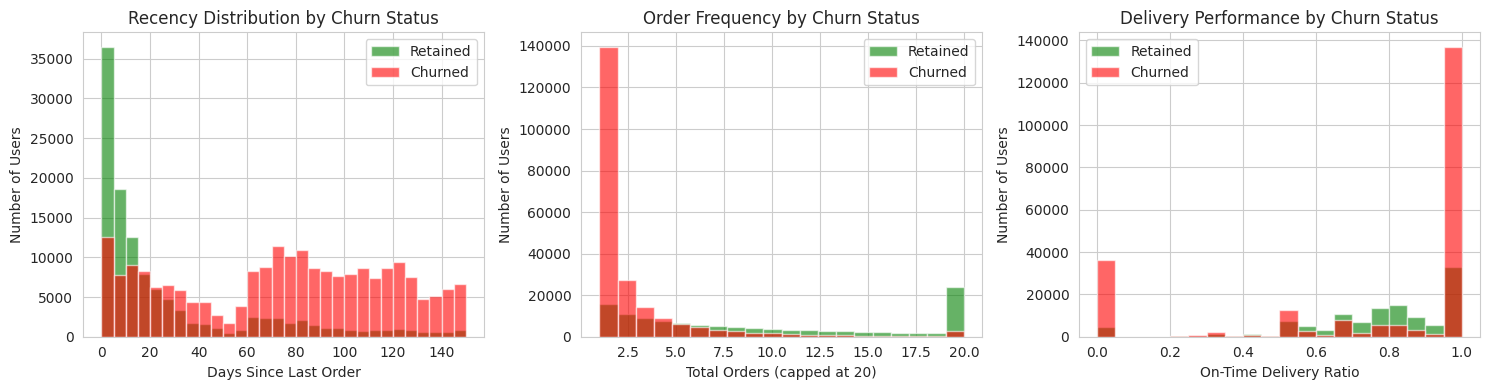

✅ Saved: reports/eda_churn_patterns.png


In [11]:
# EDA Plot 1: Churn by Recency
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Recency distribution by churn
for churned, label, color in [(0, 'Retained', 'green'), (1, 'Churned', 'red')]:
    data = user_stats[user_stats['is_churned'] == churned]['days_since_last_order']
    axes[0].hist(data, bins=30, alpha=0.6, label=label, color=color)
axes[0].set_xlabel('Days Since Last Order')
axes[0].set_ylabel('Number of Users')
axes[0].set_title('Recency Distribution by Churn Status')
axes[0].legend()

# Order count distribution by churn
for churned, label, color in [(0, 'Retained', 'green'), (1, 'Churned', 'red')]:
    data = user_stats[user_stats['is_churned'] == churned]['total_orders']
    data_clipped = data.clip(upper=20)  # Clip for visualization
    axes[1].hist(data_clipped, bins=20, alpha=0.6, label=label, color=color)
axes[1].set_xlabel('Total Orders (capped at 20)')
axes[1].set_ylabel('Number of Users')
axes[1].set_title('Order Frequency by Churn Status')
axes[1].legend()

# On-time ratio by churn
for churned, label, color in [(0, 'Retained', 'green'), (1, 'Churned', 'red')]:
    data = user_stats[user_stats['is_churned'] == churned]['on_time_ratio'].dropna()
    axes[2].hist(data, bins=20, alpha=0.6, label=label, color=color)
axes[2].set_xlabel('On-Time Delivery Ratio')
axes[2].set_ylabel('Number of Users')
axes[2].set_title('Delivery Performance by Churn Status')
axes[2].legend()

plt.tight_layout()
plt.savefig('../reports/eda_churn_patterns.png', dpi=150, bbox_inches='tight')
plt.show()
print('✅ Saved: reports/eda_churn_patterns.png')

In [12]:
# EDA: Compare means by churn status
comparison = user_stats.groupby('is_churned').agg({
    'total_orders': 'mean',
    'days_since_last_order': 'mean',
    'on_time_ratio': 'mean',
    'total_complaints': 'mean',
    'avg_shop_rating': 'mean'
}).round(3)

comparison.index = ['Retained', 'Churned']
print('📊 Mean Values by Churn Status:')
print('='*60)
display(comparison.T)

📊 Mean Values by Churn Status:


,Retained,Churned
total_orders,13.166,2.661
days_since_last_order,26.961,74.287
on_time_ratio,0.768,0.757
total_complaints,4.350,0.946
avg_shop_rating,4.261,4.253


---
## 4️⃣ Feature Engineering

In [13]:
def create_user_features(df: pd.DataFrame, observation_date: pd.Timestamp) -> pd.DataFrame:
    """
    Create user-level features from order data.
    
    IMPORTANT: Only uses data up to observation_date to prevent leakage.
    
    Args:
        df: Order-level dataframe with all columns
        observation_date: Cutoff date for feature calculation
    
    Returns:
        User-level feature dataframe
    """
    features_list = []
    
    # Group by user
    for user_id, user_data in df.groupby('user_id'):
        
        # Sort by date
        user_orders = user_data.sort_values('order_date')
        n_orders = len(user_orders)
        
        # =============================================
        # TEMPORAL / RECENCY FEATURES
        # =============================================
        first_order_date = user_orders['order_date'].min()
        last_order_date = user_orders['order_date'].max()
        
        days_since_first = (observation_date - first_order_date).days
        days_since_last = (observation_date - last_order_date).days
        customer_tenure = (last_order_date - first_order_date).days
        
        # Average days between orders
        if n_orders > 1:
            order_dates = user_orders['order_date'].sort_values()
            order_gaps = order_dates.diff().dropna().dt.days
            avg_order_gap = order_gaps.mean()
            std_order_gap = order_gaps.std() if len(order_gaps) > 1 else 0
        else:
            avg_order_gap = days_since_first  # Only one order
            std_order_gap = 0
        
        # Recent activity (last 30 days before observation)
        recent_cutoff = observation_date - timedelta(days=30)
        recent_orders = user_orders[user_orders['order_date'] > recent_cutoff]
        orders_last_30d = len(recent_orders)
        
        # Recent activity (last 7 days)
        very_recent_cutoff = observation_date - timedelta(days=7)
        orders_last_7d = len(user_orders[user_orders['order_date'] > very_recent_cutoff])
        
        # =============================================
        # DELIVERY PERFORMANCE FEATURES
        # =============================================
        # is_otd: 1=on-time, 0=late, -1=unknown
        valid_otd = user_orders[user_orders['is_otd'].isin([0, 1])]['is_otd']
        
        if len(valid_otd) > 0:
            on_time_ratio = valid_otd.mean()
            late_count = (valid_otd == 0).sum()
        else:
            on_time_ratio = np.nan  # Will handle later
            late_count = 0
        
        unknown_otd_count = (user_orders['is_otd'] == -1).sum()
        unknown_otd_ratio = unknown_otd_count / n_orders
        
        # =============================================
        # CRM / COMPLAINT FEATURES
        # =============================================
        total_complaints = user_orders['crm_delivery_request_count'].sum()
        total_fake_complaints = user_orders['crm_fake_delivery_request_count'].sum()
        complaints_per_order = total_complaints / n_orders
        
        # Orders with any complaint
        orders_with_complaint = (user_orders['crm_delivery_request_count'] > 0).sum()
        complaint_order_ratio = orders_with_complaint / n_orders
        
        # =============================================
        # RATING FEATURES
        # =============================================
        shop_ratings = user_orders['rate_to_shop'].dropna()
        courier_ratings = user_orders['rate_to_courier'].dropna()
        
        avg_shop_rating = shop_ratings.mean() if len(shop_ratings) > 0 else np.nan
        avg_courier_rating = courier_ratings.mean() if len(courier_ratings) > 0 else np.nan
        min_shop_rating = shop_ratings.min() if len(shop_ratings) > 0 else np.nan
        min_courier_rating = courier_ratings.min() if len(courier_ratings) > 0 else np.nan
        
        # Rating coverage (what % of orders have ratings)
        shop_rating_coverage = len(shop_ratings) / n_orders
        courier_rating_coverage = len(courier_ratings) / n_orders
        
        # Low rating flag (ever gave rating <= 2)
        has_low_shop_rating = 1 if (len(shop_ratings) > 0 and shop_ratings.min() <= 2) else 0
        has_low_courier_rating = 1 if (len(courier_ratings) > 0 and courier_ratings.min() <= 2) else 0
        
        # =============================================
        # COMMENT FEATURES
        # =============================================
        comments = user_orders['description'].dropna()
        has_comments = len(comments) > 0
        comment_count = len(comments)
        comment_ratio = comment_count / n_orders
        
        # Average comment length
        if has_comments:
            avg_comment_length = comments.str.len().mean()
        else:
            avg_comment_length = 0
        
        # =============================================
        # AGGREGATE FEATURES
        # =============================================
        features = {
            'user_id': user_id,
            
            # Temporal
            'total_orders': n_orders,
            'days_since_first_order': days_since_first,
            'days_since_last_order': days_since_last,
            'customer_tenure_days': customer_tenure,
            'avg_order_gap_days': avg_order_gap,
            'std_order_gap_days': std_order_gap,
            'orders_last_30d': orders_last_30d,
            'orders_last_7d': orders_last_7d,
            
            # Delivery
            'on_time_ratio': on_time_ratio,
            'late_delivery_count': late_count,
            'unknown_otd_ratio': unknown_otd_ratio,
            
            # CRM
            'total_complaints': total_complaints,
            'total_fake_complaints': total_fake_complaints,
            'complaints_per_order': complaints_per_order,
            'complaint_order_ratio': complaint_order_ratio,
            
            # Ratings
            'avg_shop_rating': avg_shop_rating,
            'avg_courier_rating': avg_courier_rating,
            'min_shop_rating': min_shop_rating,
            'min_courier_rating': min_courier_rating,
            'shop_rating_coverage': shop_rating_coverage,
            'courier_rating_coverage': courier_rating_coverage,
            'has_low_shop_rating': has_low_shop_rating,
            'has_low_courier_rating': has_low_courier_rating,
            
            # Comments
            'comment_count': comment_count,
            'comment_ratio': comment_ratio,
            'avg_comment_length': avg_comment_length,
        }
        
        features_list.append(features)
    
    return pd.DataFrame(features_list)

print('✅ Feature engineering function defined')

✅ Feature engineering function defined


In [14]:
%%time
# Generate features (this may take a few minutes for 2.7M orders)
print('⏳ Generating user features...')
print(f'   Processing {df_features["user_id"].nunique():,} users...')

user_features = create_user_features(df_features, OBSERVATION_DATE)

print(f'\n✅ Created features for {len(user_features):,} users')
print(f'   Feature count: {len(user_features.columns) - 1}')

⏳ Generating user features...
   Processing 338,101 users...

✅ Created features for 338,101 users
   Feature count: 26
CPU times: user 13min 37s, sys: 2.23 s, total: 13min 39s
Wall time: 13min 39s


In [15]:
# Add churn labels
user_features = user_features.merge(churn_labels, on='user_id', how='inner')

print(f'Dataset with labels: {len(user_features):,} users')
print(f'Churn rate: {user_features["is_churned"].mean()*100:.2f}%')
user_features.head()

Dataset with labels: 338,101 users
Churn rate: 65.01%


,user_id,total_orders,days_since_first_order,days_since_last_order,customer_tenure_days,avg_order_gap_days,std_order_gap_days,orders_last_30d,orders_last_7d,on_time_ratio,late_delivery_count,unknown_otd_ratio,total_complaints,total_fake_complaints,complaints_per_order,complaint_order_ratio,avg_shop_rating,avg_courier_rating,min_shop_rating,min_courier_rating,shop_rating_coverage,courier_rating_coverage,has_low_shop_rating,has_low_courier_rating,comment_count,comment_ratio,avg_comment_length,is_churned
0,1,19,139,3,136,7.556,9.300,4,1,0.941,1,0.105,9,0,0.474,0.368,4.333,4.750,1.000,4.000,0.632,0.211,1,0,0,0.000,0.000,0
1,4,1,102,102,0,102.000,0.000,0,0,1.000,0,0.000,0,0,0.000,0.000,NaN,NaN,NaN,NaN,0.000,0.000,0,0,0,0.000,0.000,0
2,16,2,70,70,0,0.000,0.000,0,0,1.000,0,0.000,0,0,0.000,0.000,NaN,5.000,NaN,5.000,0.000,0.500,0,0,0,0.000,0.000,0
3,40,30,138,10,128,4.414,5.760,2,0,1.000,0,0.033,8,0,0.267,0.167,4.765,5.000,1.000,5.000,0.567,0.933,1,0,0,0.000,0.000,0
4,41,2,88,5,83,83.000,0.000,1,1,1.000,0,0.000,2,0,1.000,0.500,5.000,5.000,5.000,5.000,0.500,0.500,0,0,0,0.000,0.000,1


---
## 5️⃣ Handle Missing Values

In [16]:
# Check missing values
missing = user_features.isnull().sum()
missing_pct = (missing / len(user_features) * 100).round(2)

missing_report = pd.DataFrame({
    'missing_count': missing,
    'missing_pct': missing_pct
})

print('📊 Missing Values Report:')
print(missing_report[missing_report['missing_count'] > 0].sort_values('missing_pct', ascending=False))

📊 Missing Values Report:
                    missing_count  missing_pct
avg_courier_rating         215870       63.850
min_courier_rating         215870       63.850
avg_shop_rating            163158       48.260
min_shop_rating            163158       48.260
on_time_ratio               15431        4.560


In [17]:
# Fill missing values with appropriate strategies

# Ratings: Fill with median (neutral value)
rating_cols = ['avg_shop_rating', 'avg_courier_rating', 'min_shop_rating', 'min_courier_rating']
for col in rating_cols:
    median_val = user_features[col].median()
    user_features[col] = user_features[col].fillna(median_val)
    print(f'  {col}: filled with median = {median_val:.2f}')

# on_time_ratio: Fill with overall mean (for users with only is_otd=-1)
otd_median = user_features['on_time_ratio'].median()
user_features['on_time_ratio'] = user_features['on_time_ratio'].fillna(otd_median)
print(f'  on_time_ratio: filled with median = {otd_median:.3f}')

# Verify no missing values remain
remaining_missing = user_features.isnull().sum().sum()
print(f'\n✅ Remaining missing values: {remaining_missing}')

  avg_shop_rating: filled with median = 4.87
  avg_courier_rating: filled with median = 5.00
  min_shop_rating: filled with median = 4.00
  min_courier_rating: filled with median = 5.00
  on_time_ratio: filled with median = 1.000

✅ Remaining missing values: 0


---
## 6️⃣ Feature Correlation with Churn

In [18]:
# Calculate correlation with target
feature_cols = [c for c in user_features.columns if c not in ['user_id', 'is_churned']]

correlations = user_features[feature_cols + ['is_churned']].corr()['is_churned'].drop('is_churned')
correlations = correlations.sort_values(key=abs, ascending=False)

print('📊 Feature Correlation with Churn (|correlation|):')
print('='*50)
for feat, corr in correlations.head(15).items():
    direction = '↑' if corr > 0 else '↓'
    print(f'  {feat:30s} {corr:+.4f} {direction}')

📊 Feature Correlation with Churn (|correlation|):
  customer_tenure_days           -0.5972 ↓
  days_since_last_order          +0.4840 ↑
  avg_order_gap_days             +0.3781 ↑
  late_delivery_count            -0.3764 ↓
  std_order_gap_days             -0.3326 ↓
  total_complaints               -0.3313 ↓
  has_low_shop_rating            -0.2542 ↓
  total_orders                   -0.2473 ↓
  shop_rating_coverage           -0.2260 ↓
  min_courier_rating             +0.2112 ↑
  days_since_first_order         -0.2111 ↓
  min_shop_rating                +0.1932 ↑
  courier_rating_coverage        -0.1804 ↓
  total_fake_complaints          -0.1671 ↓
  avg_comment_length             -0.1652 ↓


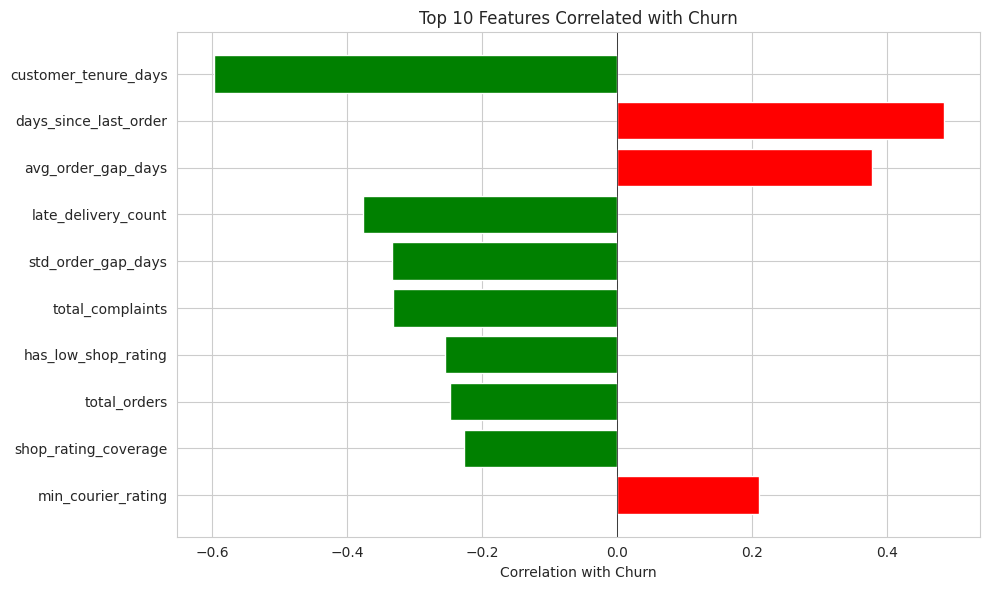

✅ Saved: reports/feature_correlations.png


In [19]:
# Visualize top correlations
top_features = correlations.head(10).index.tolist()

plt.figure(figsize=(10, 6))
colors = ['red' if c > 0 else 'green' for c in correlations.head(10)]
plt.barh(top_features[::-1], correlations.head(10).values[::-1], color=colors[::-1])
plt.xlabel('Correlation with Churn')
plt.title('Top 10 Features Correlated with Churn')
plt.axvline(x=0, color='black', linewidth=0.5)
plt.tight_layout()
plt.savefig('../reports/feature_correlations.png', dpi=150, bbox_inches='tight')
plt.show()
print('✅ Saved: reports/feature_correlations.png')

---
## 7️⃣ Feature Summary Statistics

In [20]:
# Summary statistics
print('📊 Feature Summary Statistics:')
print('='*60)
display(user_features[feature_cols].describe().T.round(3))

📊 Feature Summary Statistics:


,count,mean,std,min,25%,50%,75%,max
total_orders,338101.000,6.336,20.261,1.000,1.000,2.000,6.000,9352.000
days_since_first_order,338101.000,99.166,41.933,0.000,75.000,108.000,133.000,150.000
days_since_last_order,338101.000,57.728,46.637,0.000,12.000,60.000,97.000,150.000
customer_tenure_days,338101.000,41.438,52.617,0.000,0.000,2.000,88.000,150.000
avg_order_gap_days,338101.000,46.348,45.721,0.000,8.000,23.667,84.000,150.000
std_order_gap_days,338101.000,6.703,11.779,0.000,0.000,0.000,9.809,106.066
orders_last_30d,338101.000,1.404,16.186,0.000,0.000,0.000,1.000,9225.000
orders_last_7d,338101.000,0.336,4.188,0.000,0.000,0.000,0.000,2371.000
on_time_ratio,338101.000,0.831,0.284,0.000,0.750,1.000,1.000,1.000
late_delivery_count,338101.000,1.090,2.371,0.000,0.000,0.000,1.000,145.000


In [21]:
# Compare churned vs retained
comparison = user_features.groupby('is_churned')[feature_cols].mean().T
comparison.columns = ['Retained', 'Churned']
comparison['Diff'] = comparison['Churned'] - comparison['Retained']
comparison['Diff_Pct'] = (comparison['Diff'] / comparison['Retained'].abs() * 100).round(1)

print('📊 Feature Means: Churned vs Retained')
print('='*70)
display(comparison.sort_values('Diff_Pct', key=abs, ascending=False).round(3))

📊 Feature Means: Churned vs Retained


,Retained,Churned,Diff,Diff_Pct
days_since_last_order,26.961,74.287,47.326,175.500
avg_order_gap_days,22.784,59.031,36.247,159.100
orders_last_30d,3.346,0.359,-2.987,-89.300
orders_last_7d,0.797,0.087,-0.710,-89.000
comment_count,0.424,0.079,-0.345,-81.300
late_delivery_count,2.307,0.435,-1.872,-81.100
total_orders,13.166,2.661,-10.505,-79.800
total_fake_complaints,0.131,0.028,-0.103,-78.500
total_complaints,4.350,0.946,-3.404,-78.300
customer_tenure_days,84.271,18.385,-65.886,-78.200


---
## 8️⃣ Save Features Dataset

In [22]:
# Save to CSV
output_path = Path('../data/user_features.csv')
user_features.to_csv(output_path, index=False)

print(f'✅ Features saved to: {output_path}')
print(f'   Shape: {user_features.shape}')
print(f'   Size: {output_path.stat().st_size / 1024 / 1024:.2f} MB')

✅ Features saved to: ../data/user_features.csv
   Shape: (338101, 28)
   Size: 42.12 MB


In [23]:
# Also copy to app folder for API
app_path = Path('../app/user_features.csv')
user_features.to_csv(app_path, index=False)
print(f'✅ Also saved to: {app_path}')

✅ Also saved to: ../app/user_features.csv


---
## ✅ Summary

### Churn Definition
- **Observation Date:** 30 days before last date in data
- **Churned:** User has NO orders in 30-day window after observation date
- **Data Leakage Prevention:** Features only use data BEFORE observation date

### Features Created (26 features)

| Category | Features |
|----------|----------|
| **Temporal** | total_orders, days_since_first/last, tenure, avg/std_order_gap, orders_last_30d/7d |
| **Delivery** | on_time_ratio, late_count, unknown_otd_ratio |
| **CRM** | total_complaints, fake_complaints, complaints_per_order, complaint_order_ratio |
| **Ratings** | avg/min shop/courier rating, rating_coverage, has_low_rating flags |
| **Comments** | comment_count, comment_ratio, avg_comment_length |

### Key Findings
- **Most predictive:** days_since_last_order, orders_last_30d, orders_last_7d
- **Interpretation:** Recency is the strongest predictor of churn

### Next Step
→ **Model Training** (03_model_training.ipynb)

In [24]:
# Final dataset info
print('='*60)
print('FINAL DATASET SUMMARY')
print('='*60)
print(f'Users:        {len(user_features):,}')
print(f'Features:     {len(feature_cols)}')
print(f'Churn Rate:   {user_features["is_churned"].mean()*100:.2f}%')
print(f'Date Range:   {MIN_DATE.date()} to {OBSERVATION_DATE.date()} (features)')
print(f'Label Window: {OBSERVATION_DATE.date()} to {MAX_DATE.date()} ({CHURN_WINDOW_DAYS} days)')

FINAL DATASET SUMMARY
Users:        338,101
Features:     26
Churn Rate:   65.01%
Date Range:   2025-03-16 to 2025-08-13 (features)
Label Window: 2025-08-13 to 2025-09-12 (30 days)
